# Read an ISRed image mosaic from the butler and fit ghost spots

## Setup and imports

In [1]:
! eups list -s lsst_distrib

   g4213664e8e+b08e1c1b0b 	current w_2024_04 setup


In [2]:
# %matplotlib ipympl

# plotting
import pylab as plt
import numpy as np

# butler
from lsst.daf.butler import Butler

# isr and display
import lsst.afw.display as afwDisplay
from lsst.afw.image import Image

# camera stuff
import lsst.afw.math as afwMath
from lsst.afw.cameraGeom import utils as cgu
from lsst.obs.lsst import LsstCam

# Astropy nice plotting
from astropy.visualization import imshow_norm, MinMaxInterval, AsinhStretch, LinearStretch, \
                                  SqrtStretch,ContrastBiasStretch,ZScaleInterval, \
                                  AsymmetricPercentileInterval,ManualInterval



## Helpers

In [3]:
def displayExposure(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    afw_display.setImageColormap(cmap='gray')
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImage(image,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    #afw_display.scale('linear', min=-5, max=10)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImageGhosts(image,title=None, frame_size=16):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(frame_size,frame_size))
    afw_display = afwDisplay.Display(1)
    #afw_display.scale('asinh', 'zscale')
    afw_display.scale('linear', min=0, max=20)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    #plt.gca().axis('off')
    return afw_display

def array_from_mosaic(mosaic):
    mar = mosaic.getArray()
    mma= np.ma.filled(np.ma.masked_values(mar,0.0000),np.nan)
    return mma

def show_hv_slices(imgarray, vpix, hpix, ccdname):
    plt.rcParams["figure.figsize"] = [12, 6]
    fig, ax = plt.subplots(1, 2)
    subax = imgarray[vpix]
    x = range(len(subax))
    ax[0].plot(x, subax)
    ax[0].set_title(f'Horizontal slice on {ccdname} at pixel {vpix}')
    subay = np.transpose(imgarray)[hpix]
    y = range(len(subay))
    ax[1].plot(y, subay)
    ax[1].set_title(f'Vertical slice on {ccdname} at pixel {hpix}')

def make_stamp(x_center, y_center, ds=100):
    """ Make a stamp image around a ghost position
    """
    from lsst.geom import Point2I, Box2I
    ghost_box = Box2I(minimum=Point2I(x=x_center-ds, y=y_center-ds), maximum=Point2I(x=x_center+ds, y=y_center+ds))
    ghost_stamp = imageF[ghost_box]   # same as no ImageOrigin argument
    return ghost_stamp
    

## Connect to the Butler repository

In [4]:
import lsst.daf.butler as daf_butler
repo = "/sdf/data/rubin/repo/ir2"
butler = daf_butler.Butler(repo)

In [5]:
collections = butler.registry.queryCollections(f"u/bregeon/eo_focal_plane_mosaic*",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
for item in collections[:5]:
    print(item)

u/bregeon/eo_focal_plane_mosaic_3023062500401_w_2024_12


In [6]:
myref=list(set(butler.registry.queryDatasets(datasetType='eoFpMosaic',
                                       instrument='LSSTCam',
                                       collections=collections)))

In [7]:
imageF = butler.get(myref[0])

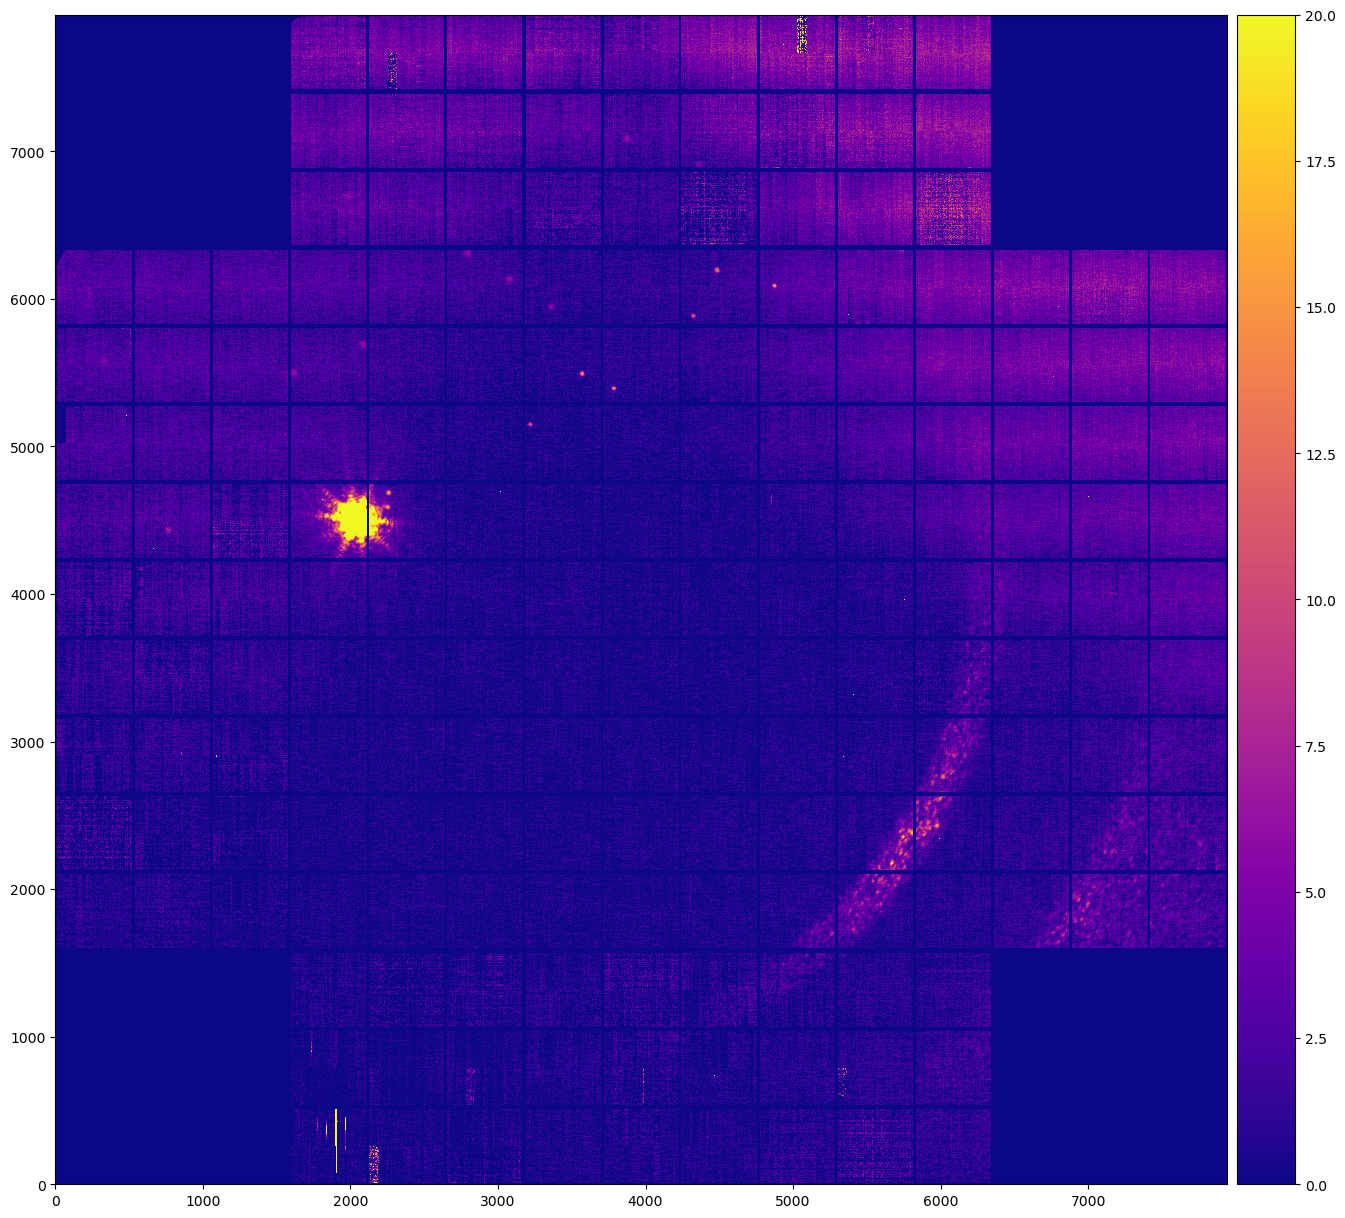

In [8]:
displayImageGhosts(imageF)
#plt.title(title)
#plt.gca().axis('off')
#afw_display.interact()
#afw_display.zoom(zoomfac=50, colc=750, rowc=4500)


In [9]:
from scipy import optimize

def gaussian(bkg, height, center_x, center_y, width):
    """Returns a gaussian function with the given parameters"""
    width = float(width)
    bkg = float(bkg)
    return lambda x,y: bkg + height*np.exp(
                -(((center_x-x)/width)**2+((center_y-y)/width)**2)/2)

def moments(data):
    """Returns (height, x, y, width)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    height = data.max()
    bkg = data.mean()
    return bkg, height, x, y, width

def fitgaussian(data):
    """Returns (height, x, y, width)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    print(params)
    return p

def ghost_fitter(ghost_stamp):
    """ Fit a 2D gaussian on a ghost stamp
    """
    # data - transpose for the fit
    stamp_array = np.transpose(ghost_stamp.getArray())
    # Fit centered in (100,100)
    params = fitgaussian(stamp_array)
    # verification
    # fit = gaussian(*params)
    # plt.matshow(cutout, cmap='plasma')
    # plt.contour(fit(*np.indices(cutout.shape)), cmap=plt.cm.copper)
    # Move Gaussian to focal plane coordinates
    rc_params = params.copy()
    rc_params[2] = params[2]+ghost_stamp.getX0()
    rc_params[3] = params[3]+ghost_stamp.getY0()
    rc_fit = gaussian(*rc_params)
    print(rc_params)
    return rc_params

def do_ghost(ghost_xy):    
    ghost_stamp = make_stamp(*ghost_xy)
    params = ghost_fitter(ghost_stamp)
    display_ghost_fit(ghost_stamp, params)


In [10]:
def display_ghost_fit(ghost_stamp, params):
    # plot ghosts stamp
    afwdisplay = displayImageGhosts(ghost_stamp, frame_size=5)
    bbox = ghost_stamp.getBBox()
    # define fit function
    gauss2d = gaussian(*params)
    # plot gaussian contours 
    plt.contour(bbox.x.range(), bbox.y.range(), gauss2d(*bbox.grid()), cmap=plt.cm.copper)
    
    ax = plt.gca()
    (bkg, height, x, y, width) = params
    plt.text(0.95, 0.05, """
    x : %.3f
    y : %.3f
    width : %.3f""" %(x, y, width),
            fontsize=16, horizontalalignment='right',
            verticalalignment='bottom', transform=ax.transAxes)
    
    print(f'Center in camera bins coordinates: {x}, {y}, {height}')
    return afwdisplay

(2.7437377, 18.012457, 101.3537770452726, 97.35469816424275, 53.213393234259186)
[2.54469742e+00 1.48208840e+01 4.87372034e+03 6.08508398e+03
 9.29265434e+00]
Center in camera bins coordinates: 4873.720342235029, 6085.083978971915, 14.82088396517016


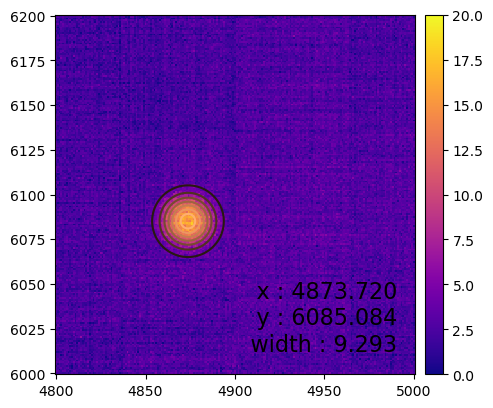

In [11]:
do_ghost((4900, 6100))

In [12]:
#show_hv_slices(imageF.getArray(), vpix=6300, hpix=2780, ccdname='random')

In [13]:
#     from lsst.afw import cameraGeom
#    tx = det.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
#    cam_x, cam_y = tx.getMapping().applyForward(np.vstack((x, y)))
#    return cam_x.ravel(), cam_y.ravel()